In [9]:
# !pip install git+https://github.com/onuralpszr/supervision.git@yolov7
# !pip install requests tqdm

In [1]:
# !# Download YOLOv7 code
# !git clone https://github.com/WongKinYiu/yolov7
# %cd yolov7

In [2]:
# # Run the detect.py script with the specified arguments
# !python detect.py --weights=yolov7.pt --img=640 --conf=0.1 --source="cam-inside-2024-05-29_14_40_14.mpg"

In [1]:
import sys
import torch
from  hubconf import yolov7
model = yolov7("yolov7-d6.pt")


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


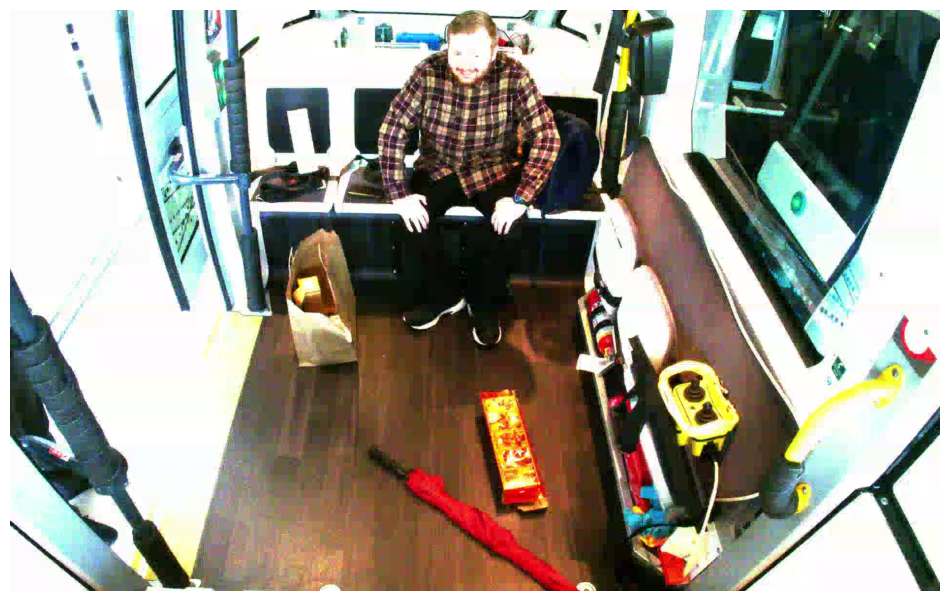

In [2]:
import supervision as sv

frames_generator = sv.get_video_frames_generator(source_path="cam-inside-2024-05-29_14_40_14.mpg")
frames_iterator = iter(frames_generator)
frame = next(frames_iterator)
%matplotlib inline
sv.plot_image(image=frame, size=(12, 12))

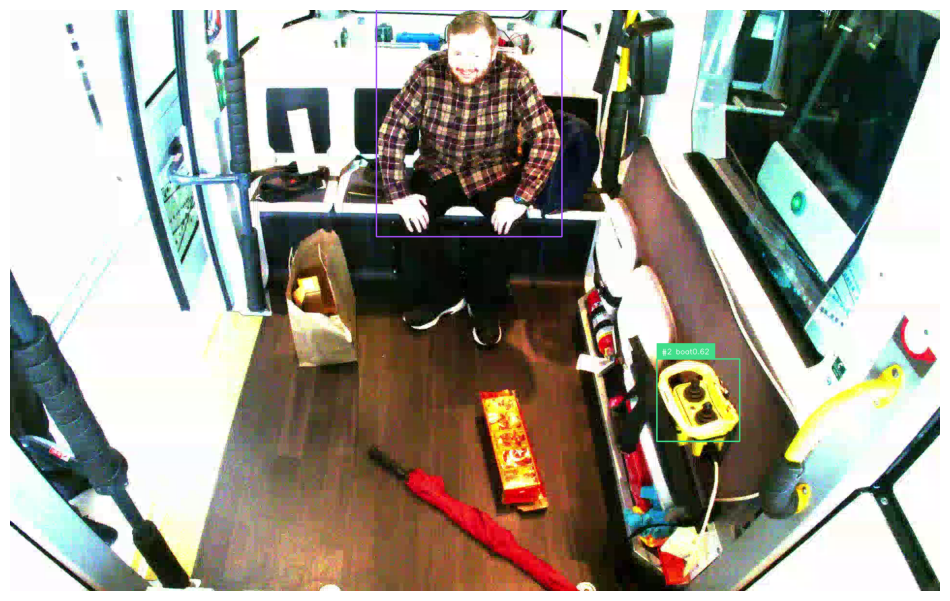

In [3]:
results = model(frame)

tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

detections = sv.Detections.from_yolov7(results)
detections = tracker.update_with_detections(detections)

labels = [
        f"#{tracker_id} {results.names[class_id]}{confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(detections.class_id, detections.confidence, detections.tracker_id)
    ]

annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

%matplotlib inline
sv.plot_image(image=annotated_frame, size=(12, 12))

In [4]:
import numpy as np
import torch
from  hubconf import yolov7, custom
import supervision as sv
model=yolov7()

tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

def callback(frame: np.ndarray, _: int) -> np.ndarray:
    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = tracker.update_with_detections(detections)

    labels = [
        f"#{tracker_id} {results.names[class_id]}{confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(detections.class_id, detections.confidence, detections.tracker_id)
    ]

    annotated_frame = box_annotator.annotate(
        frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(
        annotated_frame, detections=detections, labels=labels)
    return trace_annotator.annotate(
        annotated_frame, detections=detections)


sv.process_video(
    source_path="cam-inside-2024-05-29_14_40_14.mpg",
    target_path="annotated_video.mp4",
    callback=callback
)


                 from  n    params  module                                  arguments                     
  0                -1  1       928  models.common.Conv                      [3, 32, 3, 1]                 
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  5                -2  1      8320  models.common.Conv                      [128, 64, 1, 1]               
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


In [5]:
# model.model.names

In [6]:
# # Clone the ByteTrack repository
# !git clone https://github.com/ifzhang/ByteTrack.git

# # Change to the ByteTrack directory
# %cd ByteTrack

# # Install the required dependencies
# !pip install -r requirements.txt
# !python3 setup.py develop
# !pip install cython_bbox

# Add ByteTrack to the system path
import sys
sys.path.append("ByteTrack")

# yolov7+sv_bytetrack+counter

In [7]:
import sys
import torch
from hubconf import yolov7
import supervision as sv
import numpy as np
import cv2
import time

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
source_path = "cam-inside-2024-05-29_14_40_14.mpg"
target_path = "sv_bytetrack_counter.mp4"

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 1

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = tracker.update_with_detections(detections)

    # Count the number of persons and objects in the current frame
    num_persons = sum(1 for class_id in detections.class_id if results.names[class_id] == "person")
    num_objects = len(detections.class_id)

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(detections.class_id, detections.confidence, detections.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)

    # Add the counter information to the frame using OpenCV
    counter_info = f"Persons: {num_persons} | Objects: {num_objects} | Max Persons: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# yolov7+bytetrack+counter

In [8]:
import sys
import torch
from hubconf import yolov7
import supervision as sv
import numpy as np
import cv2
import time
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
source_path = "cam-inside-2024-05-29_14_40_14.mpg"
target_path = "bytetrack_counter.mp4"

# Initialize ByteTrack
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

tracker_args = BYTETrackerArgs()
byte_tracker = BYTETracker(tracker_args)

# Initialize annotators
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for detections
conf_threshold = 0.01

# Function to convert detections to bounding boxes with scores
def detections2boxes(detections):
    return np.hstack((detections.xyxy, detections.confidence.reshape(-1, 1)))

# Function to match detections with tracks
def match_detections_with_tracks(detections, tracks):
    if len(detections.xyxy) == 0 or len(tracks) == 0:
        return [None] * len(detections.xyxy)

    detection_boxes = detections.xyxy
    tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections.xyxy)
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id
    return tracker_ids

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)

    # Filtering detections based on confidence threshold
    detections = detections[detections.confidence > conf_threshold]

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections.class_id == person_class_id
    object_mask = detections.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections.xyxy[person_mask],
        confidence=detections.confidence[person_mask],
        class_id=detections.class_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections.xyxy[object_mask],
        confidence=detections.confidence[object_mask],
        class_id=detections.class_id[object_mask]
    )

    # Combine person and object detections for tracking
    combined_detections = sv.Detections(
        xyxy=np.vstack((person_detections.xyxy, object_detections.xyxy)),
        confidence=np.hstack((person_detections.confidence, object_detections.confidence)),
        class_id=np.hstack((person_detections.class_id, object_detections.class_id))
    )

    if len(combined_detections.xyxy) == 0:
        return frame

    # Update ByteTracker
    boxes_with_scores = detections2boxes(combined_detections)
    boxes_tensor = torch.tensor(boxes_with_scores, dtype=torch.float32)
    tracks = byte_tracker.update(boxes_tensor, frame.shape, frame.shape)
    tracker_ids = match_detections_with_tracks(combined_detections, tracks)
    combined_detections.tracker_id = np.array(tracker_ids)

    # Filter detections without tracker IDs
    mask = np.array([tracker_id is not None for tracker_id in combined_detections.tracker_id], dtype=bool)
    combined_detections = sv.Detections(
        xyxy=combined_detections.xyxy[mask],
        confidence=combined_detections.confidence[mask],
        class_id=combined_detections.class_id[mask],
        tracker_id=combined_detections.tracker_id[mask]
    )

    # Count the number of persons and objects in the current frame
    num_persons = sum(1 for class_id in combined_detections.class_id if class_id == person_class_id)
    num_objects = len(combined_detections.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(combined_detections.class_id, combined_detections.confidence, combined_detections.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=combined_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=combined_detections, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=combined_detections)

    # Add the counter information to the frame using OpenCV
    counter_info = f"Persons: {num_persons} | Objects: {num_objects} | Max Persons: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


D:\00 MSA\08 Summer Practicum\yolov7-main\ByteTrack\yolox\tracker\byte_tracker.py:182: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  dets_second = bboxes[inds_second]
D:\00 MSA\08 Summer Practicum\yolov7-main\ByteTrack\yolox\tracker\byte_tracker.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ..\aten\src\ATen/native/IndexingUtils.h:28.)
  scores_second = scores[inds_second]


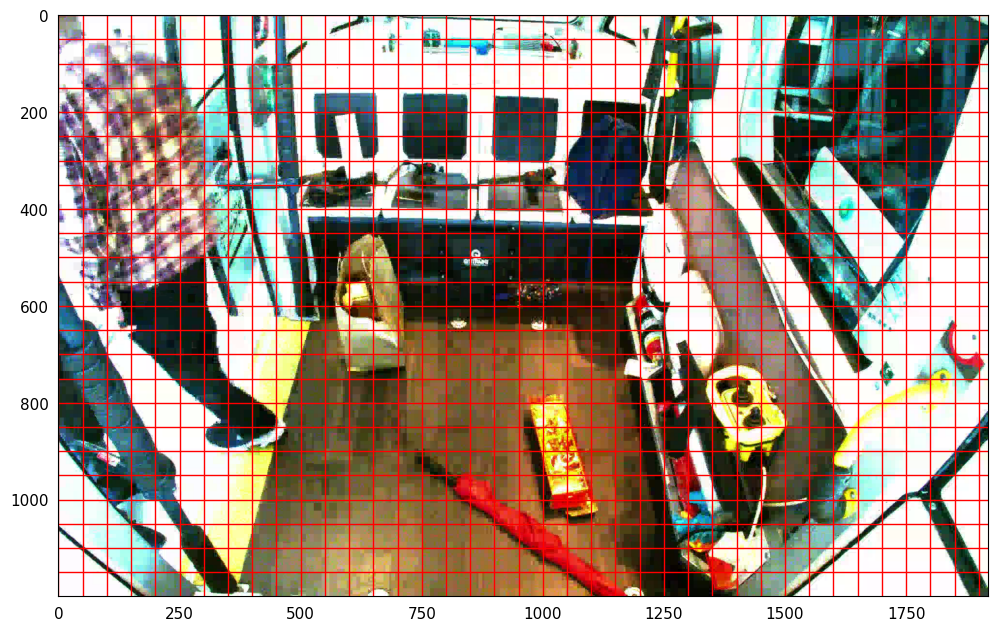

In [9]:
import cv2
import matplotlib.pyplot as plt

# Function to extract a frame from the video
def extract_frame(video_path, frame_number=0):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    ret, frame = cap.read()
    cap.release()
    return frame if ret else None

# Function to plot the image with grid
def plot_image_with_grid(image, grid_size=(50, 50)):
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    # Draw grid lines
    x_ticks = range(0, image.shape[1], grid_size[0])
    y_ticks = range(0, image.shape[0], grid_size[1])
    ax.set_xticks(x_ticks, minor=True)
    ax.set_yticks(y_ticks, minor=True)
    
    ax.grid(which='both', color='red', linestyle='-', linewidth=1)
    ax.tick_params(which='both', bottom=False, left=False, labelbottom=True, labelleft=True)
    
    plt.show()

# Path to the video file
video_path = "cam-inside-2024-05-29_14_40_14.mpg"  # Replace with your video path

# Extract a frame from the video
frame = extract_frame(video_path, frame_number=100)

# Plot the frame with grid
if frame is not None:
    plot_image_with_grid(frame, grid_size=(50, 50))
else:
    print("Failed to extract the frame from the video.")


# yolov7+sv_bytetrack+counter+zone

In [10]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
source_path = "cam-inside-2024-05-29_14_40_14.mpg"
target_path = "sv_bytetrack_counter_zone.mp4"

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 1

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with coordinates from the provided image
polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.GREEN, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold
    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# yolov7+bytetrack+counter+zone

In [11]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
# source_path = "cam-inside-2024-05-29_14_36_07.mpg"
source_path = "cam-inside-2024-05-29_14_40_14.mpg"
target_path = "bytetrack_counter_zone.mp4"

# Initialize ByteTrack
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

tracker_args = BYTETrackerArgs()
byte_tracker = BYTETracker(tracker_args)

# Initialize annotators
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for detections
conf_threshold = 0.1

# Define the polygon zone with coordinates
polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to convert detections to bounding boxes with scores
def detections2boxes(detections):
    return np.hstack((detections.xyxy, detections.confidence.reshape(-1, 1)))

# Function to match detections with tracks
def match_detections_with_tracks(detections, tracks):
    if len(detections.xyxy) == 0 or len(tracks) == 0:
        return [None] * len(detections.xyxy)

    detection_boxes = detections.xyxy
    tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections.xyxy)
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id
    return tracker_ids

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.GREEN, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)

    # Filtering detections based on confidence threshold
    detections = detections[detections.confidence > conf_threshold]

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections.class_id == person_class_id
    object_mask = detections.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections.xyxy[person_mask],
        confidence=detections.confidence[person_mask],
        class_id=detections.class_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections.xyxy[object_mask],
        confidence=detections.confidence[object_mask],
        class_id=detections.class_id[object_mask]
    )

    # Combine person and object detections for tracking
    combined_detections = sv.Detections(
        xyxy=np.vstack((person_detections.xyxy, object_detections.xyxy)),
        confidence=np.hstack((person_detections.confidence, object_detections.confidence)),
        class_id=np.hstack((person_detections.class_id, object_detections.class_id))
    )

    if len(combined_detections.xyxy) == 0:
        return frame

    # Update ByteTracker
    boxes_with_scores = detections2boxes(combined_detections)
    boxes_tensor = torch.tensor(boxes_with_scores, dtype=torch.float32)
    tracks = byte_tracker.update(boxes_tensor, frame.shape, frame.shape)
    tracker_ids = match_detections_with_tracks(combined_detections, tracks)
    combined_detections.tracker_id = np.array(tracker_ids)

    # Filter detections without tracker IDs
    mask = np.array([tracker_id is not None for tracker_id in combined_detections.tracker_id], dtype=bool)
    combined_detections = sv.Detections(
        xyxy=combined_detections.xyxy[mask],
        confidence=combined_detections.confidence[mask],
        class_id=combined_detections.class_id[mask],
        tracker_id=combined_detections.tracker_id[mask]
    )

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=combined_detections)
    detections_in_zone = sv.Detections(
        xyxy=combined_detections.xyxy[polygon_mask],
        confidence=combined_detections.confidence[polygon_mask],
        class_id=combined_detections.class_id[polygon_mask],
        tracker_id=combined_detections.tracker_id[polygon_mask]
    )

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if class_id == person_class_id)
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(combined_detections.class_id, combined_detections.confidence, combined_detections.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=combined_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=combined_detections, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=combined_detections)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

        # Play sound alert
        # os.system('afplay alert_sound.wav')  # macOS
        # os.system('aplay alert_sound.wav')  # Linux
        # os.system('start alert_sound.wav')  # Windows

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# buffer, so if object is detected for x % in that 5 sec window

In [12]:
# import sys
# import torch
# from hubconf import custom
# import supervision as sv
# import numpy as np
# import cv2
# import time
# from yolox.tracker.byte_tracker import BYTETracker, STrack
# from onemetric.cv.utils.iou import box_iou_batch
# from dataclasses import dataclass
# import os

# # Load YOLOv7 model with specific weights
# model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# # Define the video source and target paths
# source_path = "cam-inside-2024-05-29_14_40_14.mpg"
# target_path = "buffer.mp4"

# # Initialize ByteTrack
# @dataclass(frozen=True)
# class BYTETrackerArgs:
#     track_thresh: float = 0.25
#     track_buffer: int = 30
#     match_thresh: float = 0.8
#     aspect_ratio_thresh: float = 3.0
#     min_box_area: float = 1.0
#     mot20: bool = False

# tracker_args = BYTETrackerArgs()
# byte_tracker = BYTETracker(tracker_args)

# # Initialize annotators
# box_annotator = sv.BoundingBoxAnnotator()
# label_annotator = sv.LabelAnnotator()
# trace_annotator = sv.TraceAnnotator()

# # Initialize counters and timer
# max_persons = 0
# max_objects = 0
# alert_triggered = False
# object_presence_buffer = []

# # User-defined alert duration in seconds
# alert_duration = 3  # 5 seconds
# frame_rate = 30  # Assuming 30 frames per second
# buffer_size = alert_duration * frame_rate
# object_presence_buffer = [False] * buffer_size  # Pre-fill the buffer

# # Confidence threshold for detections
# conf_threshold = 0.1

# # Define the polygon zone with coordinates
# polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
# polygon_zone = None  # Placeholder for the polygon zone
# polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# # Function to convert detections to bounding boxes with scores
# def detections2boxes(detections):
#     return np.hstack((detections.xyxy, detections.confidence.reshape(-1, 1)))

# # Function to match detections with tracks
# def match_detections_with_tracks(detections, tracks):
#     if len(detections.xyxy) == 0 or len(tracks) == 0:
#         return [None] * len(detections.xyxy)

#     detection_boxes = detections.xyxy
#     tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
#     iou = box_iou_batch(tracks_boxes, detection_boxes)
#     track2detection = np.argmax(iou, axis=1)

#     tracker_ids = [None] * len(detections.xyxy)
#     for tracker_index, detection_index in enumerate(track2detection):
#         if iou[tracker_index, detection_index] != 0:
#             tracker_ids[detection_index] = tracks[tracker_index].track_id
#     return tracker_ids

# # Define the callback function for processing frames
# def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
#     global max_persons, max_objects, alert_triggered, polygon_zone, polygon_zone_annotator, object_presence_buffer

#     # Initialize the polygon zone with frame dimensions
#     if polygon_zone is None:
#         frame_height, frame_width = frame.shape[:2]
#         polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
#         polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.GREEN, thickness=2)

#     results = model(frame)
#     detections = sv.Detections.from_yolov7(results)

#     # Filtering detections based on confidence threshold
#     detections = detections[detections.confidence > conf_threshold]

#     # Get class ID for "person"
#     person_class_id = results.names.index("person")

#     # Filtering detections to separate persons and other objects
#     person_mask = detections.class_id == person_class_id
#     object_mask = detections.class_id != person_class_id

#     person_detections = sv.Detections(
#         xyxy=detections.xyxy[person_mask],
#         confidence=detections.confidence[person_mask],
#         class_id=detections.class_id[person_mask]
#     )

#     object_detections = sv.Detections(
#         xyxy=detections.xyxy[object_mask],
#         confidence=detections.confidence[object_mask],
#         class_id=detections.class_id[object_mask]
#     )

#     # Combine person and object detections for tracking
#     combined_detections = sv.Detections(
#         xyxy=np.vstack((person_detections.xyxy, object_detections.xyxy)),
#         confidence=np.hstack((person_detections.confidence, object_detections.confidence)),
#         class_id=np.hstack((person_detections.class_id, object_detections.class_id))
#     )

#     # Update object presence buffer
#     if len(object_detections.xyxy) > 0:
#         object_presence_buffer.append(True)
#     else:
#         object_presence_buffer.append(False)

#     if len(object_presence_buffer) > buffer_size:
#         object_presence_buffer.pop(0)

#     # Check if the object is present in at least 60% of the frames in the buffer
#     if len(object_presence_buffer) == buffer_size:
#         presence_ratio = sum(object_presence_buffer) / buffer_size
#         if presence_ratio >= 0.6:
#             alert_triggered = True
#         else:
#             alert_triggered = False
#     else:
#         alert_triggered = False

#     if len(combined_detections.xyxy) == 0:
#         return frame

#     # Update ByteTracker
#     boxes_with_scores = detections2boxes(combined_detections)
#     boxes_tensor = torch.tensor(boxes_with_scores, dtype=torch.float32)
#     tracks = byte_tracker.update(boxes_tensor, frame.shape, frame.shape)
#     tracker_ids = match_detections_with_tracks(combined_detections, tracks)
#     combined_detections.tracker_id = np.array(tracker_ids)

#     # Filter detections without tracker IDs
#     mask = np.array([tracker_id is not None for tracker_id in combined_detections.tracker_id], dtype=bool)
#     combined_detections = sv.Detections(
#         xyxy=combined_detections.xyxy[mask],
#         confidence=combined_detections.confidence[mask],
#         class_id=combined_detections.class_id[mask],
#         tracker_id=combined_detections.tracker_id[mask]
#     )

#     # Apply the polygon zone mask to the detections
#     polygon_mask = polygon_zone.trigger(detections=combined_detections)
#     detections_in_zone = sv.Detections(
#         xyxy=combined_detections.xyxy[polygon_mask],
#         confidence=combined_detections.confidence[polygon_mask],
#         class_id=combined_detections.class_id[polygon_mask],
#         tracker_id=combined_detections.tracker_id[polygon_mask]
#     )

#     # Count the number of persons and objects in the current frame within the zone
#     num_persons = sum(1 for class_id in detections_in_zone.class_id if class_id == person_class_id)
#     num_objects = len(detections_in_zone.class_id) - num_persons

#     # Update the maximum counts
#     max_persons = max(max_persons, num_persons)
#     max_objects = max(max_objects, num_objects)

#     # Create labels for the detections
#     labels = [
#         f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
#         for class_id, confidence, tracker_id
#         in zip(combined_detections.class_id, combined_detections.confidence, combined_detections.tracker_id)
#     ]

#     # Annotate the frame with bounding boxes, labels, and traces
#     annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=combined_detections)
#     annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=combined_detections, labels=labels)
#     annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=combined_detections)

#     # Annotate the frame with the polygon zone and count of detected objects within the zone
#     annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

#     # Add the counter information to the frame using OpenCV
#     counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
#     position = (10, annotated_frame.shape[0] - 10)
#     font_scale = 1.0
#     color = (255, 255, 255)
#     thickness = 2
#     cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

#     # Add alert message if triggered
#     if alert_triggered:
#         alert_text = "ALERT: No people, item left behind!"
#         alert_position = (10, 50)
#         alert_color = (0, 0, 255)  # Red color for alert
#         cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

#         # Play sound alert
#         # os.system('afplay alert_sound.wav')  # macOS
#         # os.system('aplay alert_sound.wav')  # Linux
#         os.system('start alert_sound.wav')  # Windows

#     return annotated_frame

# # Process the video with the defined callback
# sv.process_video(source_path=source_path, target_path=target_path, callback=callback)


# skip every 3rd frame

In [13]:
# import sys
# import torch
# from hubconf import custom
# import supervision as sv
# import numpy as np
# import cv2
# import time
# from yolox.tracker.byte_tracker import BYTETracker, STrack
# from onemetric.cv.utils.iou import box_iou_batch
# from dataclasses import dataclass
# import os

# # Load YOLOv7 model with specific weights
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = custom(path_or_model="yolov7-d6.pt", autoshape=True).to(device)

# # Define the video source and target paths
# source_path = "cam-inside-2024-05-29_14_40_14.mpg"
# target_path = "buffer_skip_frame.mp4"

# # Initialize ByteTrack
# @dataclass(frozen=True)
# class BYTETrackerArgs:
#     track_thresh: float = 0.25
#     track_buffer: int = 30
#     match_thresh: float = 0.8
#     aspect_ratio_thresh: float = 3.0
#     min_box_area: float = 1.0
#     mot20: bool = False

# tracker_args = BYTETrackerArgs()
# byte_tracker = BYTETracker(tracker_args)

# # Initialize annotators
# box_annotator = sv.BoundingBoxAnnotator()
# label_annotator = sv.LabelAnnotator()
# trace_annotator = sv.TraceAnnotator()

# # Initialize counters and timer
# max_persons = 0
# max_objects = 0
# alert_triggered = False
# object_presence_buffer = []

# # User-defined alert duration in seconds
# alert_duration = 5  # 5 seconds
# frame_rate = 30  # Assuming 30 frames per second
# buffer_size = alert_duration * frame_rate
# object_presence_buffer = [False] * buffer_size  # Pre-fill the buffer

# # Confidence threshold for detections
# conf_threshold = 0.1

# # Define the polygon zone with coordinates
# polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
# polygon_zone = None  # Placeholder for the polygon zone
# polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# frame_skip = 3  # Process every third frame

# # Function to convert detections to bounding boxes with scores
# def detections2boxes(detections):
#     return np.hstack((detections.xyxy, detections.confidence.reshape(-1, 1)))

# # Function to match detections with tracks
# def match_detections_with_tracks(detections, tracks):
#     if len(detections.xyxy) == 0 or len(tracks) == 0:
#         return [None] * len(detections.xyxy)

#     detection_boxes = detections.xyxy
#     tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
#     iou = box_iou_batch(tracks_boxes, detection_boxes)
#     track2detection = np.argmax(iou, axis=1)

#     tracker_ids = [None] * len(detections.xyxy)
#     for tracker_index, detection_index in enumerate(track2detection):
#         if iou[tracker_index, detection_index] != 0:
#             tracker_ids[detection_index] = tracks[tracker_index].track_id
#     return tracker_ids

# # Define the callback function for processing frames
# def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
#     global max_persons, max_objects, alert_triggered, polygon_zone, polygon_zone_annotator, object_presence_buffer

#     if frame_index % frame_skip != 0:
#         return frame

#     # Initialize the polygon zone with frame dimensions
#     if polygon_zone is None:
#         frame_height, frame_width = frame.shape[:2]
#         polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
#         polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.GREEN, thickness=2)

#     frame_tensor = torch.from_numpy(frame).to(device).permute(2, 0, 1).float().unsqueeze(0) / 255.0
#     results = model(frame_tensor)[0]

#     detections = sv.Detections.from_yolov7(results)
#     detections = detections[detections.confidence > conf_threshold]

#     person_class_id = results.names.index("person")

#     person_mask = detections.class_id == person_class_id
#     object_mask = detections.class_id != person_class_id

#     person_detections = sv.Detections(
#         xyxy=detections.xyxy[person_mask],
#         confidence=detections.confidence[person_mask],
#         class_id=detections.class_id[person_mask]
#     )

#     object_detections = sv.Detections(
#         xyxy=detections.xyxy[object_mask],
#         confidence=detections.confidence[object_mask],
#         class_id=detections.class_id[object_mask]
#     )

#     combined_detections = sv.Detections(
#         xyxy=np.vstack((person_detections.xyxy, object_detections.xyxy)),
#         confidence=np.hstack((person_detections.confidence, object_detections.confidence)),
#         class_id=np.hstack((person_detections.class_id, object_detections.class_id))
#     )

#     if len(object_detections.xyxy) > 0:
#         object_presence_buffer.append(True)
#     else:
#         object_presence_buffer.append(False)

#     if len(object_presence_buffer) > buffer_size:
#         object_presence_buffer.pop(0)

#     if len(object_presence_buffer) == buffer_size:
#         presence_ratio = sum(object_presence_buffer) / buffer_size
#         if presence_ratio >= 0.6:
#             alert_triggered = True
#         else:
#             alert_triggered = False
#     else:
#         alert_triggered = False

#     if len(combined_detections.xyxy) == 0:
#         return frame

#     boxes_with_scores = detections2boxes(combined_detections)
#     boxes_tensor = torch.tensor(boxes_with_scores, dtype=torch.float32).to(device)
#     tracks = byte_tracker.update(boxes_tensor.cpu(), frame.shape, frame.shape)
#     tracker_ids = match_detections_with_tracks(combined_detections, tracks)
#     combined_detections.tracker_id = np.array(tracker_ids)

#     mask = np.array([tracker_id is not None for tracker_id in combined_detections.tracker_id], dtype=bool)
#     combined_detections = sv.Detections(
#         xyxy=combined_detections.xyxy[mask],
#         confidence=combined_detections.confidence[mask],
#         class_id=combined_detections.class_id[mask],
#         tracker_id=combined_detections.tracker_id[mask]
#     )

#     polygon_mask = polygon_zone.trigger(detections=combined_detections)
#     detections_in_zone = sv.Detections(
#         xyxy=combined_detections.xyxy[polygon_mask],
#         confidence=combined_detections.confidence[polygon_mask],
#         class_id=combined_detections.class_id[polygon_mask],
#         tracker_id=combined_detections.tracker_id[polygon_mask]
#     )

#     num_persons = sum(1 for class_id in detections_in_zone.class_id if class_id == person_class_id)
#     num_objects = len(detections_in_zone.class_id) - num_persons

#     max_persons = max(max_persons, num_persons)
#     max_objects = max(max_objects, num_objects)

#     labels = [
#         f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
#         for class_id, confidence, tracker_id
#         in zip(combined_detections.class_id, combined_detections.confidence, combined_detections.tracker_id)
#     ]

#     annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=combined_detections)
#     annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=combined_detections, labels=labels)
#     annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=combined_detections)

#     annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

#     counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
#     position = (10, annotated_frame.shape[0] - 10)
#     font_scale = 1.0
#     color = (255, 255, 255)
#     thickness = 2
#     cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

#     if alert_triggered:
#         alert_text = "ALERT: No people, item left behind!"
#         alert_position = (10, 50)
#         alert_color = (0, 0, 255)  # Red color for alert
#         cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

#         # Play sound alert
#         os.system('afplay alert_sound.wav')  # macOS
#         # os.system('aplay alert_sound.wav')  # Linux
#         # os.system('start alert_sound.wav')  # Windows

#     return annotated_frame

# # Process the video with the defined callback
# sv.process_video(source_path=source_path, target_path=target_path, callback=callback)


# sv_bytetrack filter out detections outside zone

In [14]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
source_path = "cam-inside-2024-05-29_14_40_14.mpg"
target_path = "sv_bytetrack_counter_zone.mp4"

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with coordinates from the provided image
polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# bytetrack filter out detections outside zone

In [15]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
from yolox.tracker.byte_tracker import BYTETracker, STrack
from onemetric.cv.utils.iou import box_iou_batch
from dataclasses import dataclass

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the video source and target paths
source_path = "merged_video.mp4"
target_path = "result_2.mp4"

# Initialize ByteTrack
@dataclass(frozen=True)
class BYTETrackerArgs:
    track_thresh: float = 0.25
    track_buffer: int = 30
    match_thresh: float = 0.8
    aspect_ratio_thresh: float = 3.0
    min_box_area: float = 1.0
    mot20: bool = False

tracker_args = BYTETrackerArgs()
byte_tracker = BYTETracker(tracker_args)

# Initialize annotators
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# Initialize counters and timer
max_persons = 0
max_objects = 0
alert_triggered = False
last_person_seen_time = None

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for detections
conf_threshold = 0.1

# Define the polygon zone with coordinates
polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to convert detections to bounding boxes with scores
def detections2boxes(detections):
    return np.hstack((detections.xyxy, detections.confidence.reshape(-1, 1)))

# Function to match detections with tracks
def match_detections_with_tracks(detections, tracks):
    if len(detections.xyxy) == 0 or len(tracks) == 0:
        return [None] * len(detections.xyxy)

    detection_boxes = detections.xyxy
    tracks_boxes = np.array([track.tlbr for track in tracks], dtype=float)
    iou = box_iou_batch(tracks_boxes, detection_boxes)
    track2detection = np.argmax(iou, axis=1)

    tracker_ids = [None] * len(detections.xyxy)
    for tracker_index, detection_index in enumerate(track2detection):
        if iou[tracker_index, detection_index] != 0:
            tracker_ids[detection_index] = tracks[tracker_index].track_id
    return tracker_ids

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color(255, 255, 0), thickness=2)  # Bright yellow color

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)

    # Filtering detections based on confidence threshold
    detections = detections[detections.confidence > conf_threshold]

    # Filter detections based on relative area
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections = detections[polygon_mask]  # Filter out detections outside the polygon

    if len(detections.xyxy) == 0:
        return frame

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections.class_id == person_class_id
    object_mask = detections.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections.xyxy[person_mask],
        confidence=detections.confidence[person_mask],
        class_id=detections.class_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections.xyxy[object_mask],
        confidence=detections.confidence[object_mask],
        class_id=detections.class_id[object_mask]
    )

    # Combine person and object detections for tracking
    combined_detections = sv.Detections(
        xyxy=np.vstack((person_detections.xyxy, object_detections.xyxy)),
        confidence=np.hstack((person_detections.confidence, object_detections.confidence)),
        class_id=np.hstack((person_detections.class_id, object_detections.class_id))
    )

    # Update ByteTracker
    boxes_with_scores = detections2boxes(combined_detections)
    boxes_tensor = torch.tensor(boxes_with_scores, dtype=torch.float32)
    tracks = byte_tracker.update(boxes_tensor, frame.shape, frame.shape)
    tracker_ids = match_detections_with_tracks(combined_detections, tracks)
    combined_detections.tracker_id = np.array(tracker_ids)

    # Filter detections without tracker IDs
    mask = np.array([tracker_id is not None for tracker_id in combined_detections.tracker_id], dtype=bool)
    combined_detections = sv.Detections(
        xyxy=combined_detections.xyxy[mask],
        confidence=combined_detections.confidence[mask],
        class_id=combined_detections.class_id[mask],
        tracker_id=combined_detections.tracker_id[mask]
    )

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in combined_detections.class_id if class_id == person_class_id)
    num_objects = len(combined_detections.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if there are no people and objects are still present
    current_time = time.time()
    if num_persons == 0 and num_objects > 0:
        if last_person_seen_time is None:
            last_person_seen_time = current_time
        elif current_time - last_person_seen_time >= alert_duration:
            alert_triggered = True
    else:
        last_person_seen_time = None
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        for class_id, confidence, tracker_id
        in zip(combined_detections.class_id, combined_detections.confidence, combined_detections.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=combined_detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=combined_detections, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=combined_detections)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: No people, item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process the video with the defined callback
sv.process_video(source_path=source_path, target_path=target_path, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# Proximity-Based Assignment sv_bytetrack

In [1]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the list of video files
video_files = [
    "cam-inside-2024-05-29_14_36_07.mpg",
    "cam-inside-2024-05-29_14_37_13.mpg",
    "cam-inside-2024-05-29_14_38_21.mpg",
    "cam-inside-2024-05-29_14_39_07.mpg",
    "cam-inside-2024-05-29_14_40_14.mpg",
    "cam-inside-2024-05-29_14_41_21.mpg",
    "cam-inside-2024-05-29_14_42_06.mpg",
    "cam-inside-2024-05-29_14_43_12.mpg",
    "cam-inside-2024-05-29_14_44_15.mpg",
    "cam-inside-2024-05-29_14_45_19.mpg",
    "cam-inside-2024-05-29_14_46_02.mpg",
    "cam-inside-2024-05-29_14_47_09.mpg",
    "cam-inside-2024-05-29_14_48_13.mpg"
]

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with coordinates from the provided image
polygon = np.array([[250, 1200], [450, 150], [1200, 150], [1300, 1200]])

# Function to initialize global variables
def initialize_globals():
    global max_persons, max_objects, alert_triggered, last_person_seen_time, object_to_person, missing_times, polygon_zone, polygon_zone_annotator
    max_persons = 0
    max_objects = 0
    alert_triggered = False
    last_person_seen_time = None
    object_to_person = {}
    missing_times = {}
    polygon_zone = None  # Placeholder for the polygon zone
    polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to assign objects to the nearest person
def assign_possession(person_detections, object_detections):
    object_to_person = {}
    for i, obj in enumerate(object_detections.xyxy):
        obj_center = [(obj[0] + obj[2]) / 2, (obj[1] + obj[3]) / 2]
        min_distance = float('inf')
        assigned_person = None
        for j, person in enumerate(person_detections.xyxy):
            person_center = [(person[0] + person[2]) / 2, (person[1] + person[3]) / 2]
            distance = np.linalg.norm(np.array(obj_center) - np.array(person_center))
            if distance < min_distance:
                min_distance = distance
                assigned_person = person_detections.tracker_id[j]
        object_to_person[object_detections.tracker_id[i]] = assigned_person
    return object_to_person

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator, object_to_person, missing_times

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections_in_zone.class_id == person_class_id
    object_mask = detections_in_zone.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[person_mask],
        confidence=detections_in_zone.confidence[person_mask],
        class_id=detections_in_zone.class_id[person_mask],
        tracker_id=detections_in_zone.tracker_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[object_mask],
        confidence=detections_in_zone.confidence[object_mask],
        class_id=detections_in_zone.class_id[object_mask],
        tracker_id=detections_in_zone.tracker_id[object_mask]
    )

    # Assign possession based on proximity
    object_to_person = assign_possession(person_detections, object_detections)

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if the assigned person for any object is no longer present
    current_time = time.time()
    persons_present = set(detections_in_zone.tracker_id[detections_in_zone.class_id == person_class_id])
    for obj_id, person_id in object_to_person.items():
        if person_id not in persons_present:
            if obj_id not in missing_times:
                missing_times[obj_id] = current_time
            elif current_time - missing_times[obj_id] >= alert_duration:
                alert_triggered = True
                break
        else:
            if obj_id in missing_times:
                del missing_times[obj_id]
    else:
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        if results.names[class_id] == "person" else 
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f} | Owner: {object_to_person.get(tracker_id, 'N/A')}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: Item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process each video with the defined callback
for video_file in video_files:
    initialize_globals()  # Reset global variables for each video
    target_file = f"processed_v1_px_{video_file}"
    sv.process_video(source_path=video_file, target_path=target_file, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# Updated Zone Size

In [2]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the list of video files
video_files = [
    "cam-inside-2024-05-29_14_36_07.mpg",
    "cam-inside-2024-05-29_14_37_13.mpg",
    "cam-inside-2024-05-29_14_38_21.mpg",
    "cam-inside-2024-05-29_14_39_07.mpg",
    "cam-inside-2024-05-29_14_40_14.mpg",
    "cam-inside-2024-05-29_14_41_21.mpg",
    "cam-inside-2024-05-29_14_42_06.mpg",
    "cam-inside-2024-05-29_14_43_12.mpg",
    "cam-inside-2024-05-29_14_44_15.mpg",
    "cam-inside-2024-05-29_14_45_19.mpg",
    "cam-inside-2024-05-29_14_46_02.mpg",
    "cam-inside-2024-05-29_14_47_09.mpg",
    "cam-inside-2024-05-29_14_48_13.mpg"
]

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with coordinates from the provided image
# polygon = np.array([[0, 1200], [400, 150], [1300, 150], [1900, 1200]])
polygon = np.array([[0, 1200], [400, 150], [1300, 150], [1450, 1200]])

# Function to initialize global variables
def initialize_globals():
    global max_persons, max_objects, alert_triggered, last_person_seen_time, object_to_person, missing_times, polygon_zone, polygon_zone_annotator
    max_persons = 0
    max_objects = 0
    alert_triggered = False
    last_person_seen_time = None
    object_to_person = {}
    missing_times = {}
    polygon_zone = None  # Placeholder for the polygon zone
    polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to assign objects to the nearest person
def assign_possession(person_detections, object_detections):
    object_to_person = {}
    for i, obj in enumerate(object_detections.xyxy):
        obj_center = [(obj[0] + obj[2]) / 2, (obj[1] + obj[3]) / 2]
        min_distance = float('inf')
        assigned_person = None
        for j, person in enumerate(person_detections.xyxy):
            person_center = [(person[0] + person[2]) / 2, (person[1] + person[3]) / 2]
            distance = np.linalg.norm(np.array(obj_center) - np.array(person_center))
            if distance < min_distance:
                min_distance = distance
                assigned_person = person_detections.tracker_id[j]
        object_to_person[object_detections.tracker_id[i]] = assigned_person
    return object_to_person

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator, object_to_person, missing_times

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections_in_zone.class_id == person_class_id
    object_mask = detections_in_zone.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[person_mask],
        confidence=detections_in_zone.confidence[person_mask],
        class_id=detections_in_zone.class_id[person_mask],
        tracker_id=detections_in_zone.tracker_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[object_mask],
        confidence=detections_in_zone.confidence[object_mask],
        class_id=detections_in_zone.class_id[object_mask],
        tracker_id=detections_in_zone.tracker_id[object_mask]
    )

    # Assign possession based on proximity
    object_to_person = assign_possession(person_detections, object_detections)

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if the assigned person for any object is no longer present
    current_time = time.time()
    persons_present = set(detections_in_zone.tracker_id[detections_in_zone.class_id == person_class_id])
    for obj_id, person_id in object_to_person.items():
        if person_id not in persons_present:
            if obj_id not in missing_times:
                missing_times[obj_id] = current_time
            elif current_time - missing_times[obj_id] >= alert_duration:
                alert_triggered = True
                break
        else:
            if obj_id in missing_times:
                del missing_times[obj_id]
    else:
        alert_triggered = False

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        if results.names[class_id] == "person" else 
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f} | Owner: {object_to_person.get(tracker_id, 'N/A')}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: Item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process each video with the defined callback
for video_file in video_files:
    initialize_globals()  # Reset global variables for each video
    target_file = f"processed_v2_px_z_{video_file}"
    sv.process_video(source_path=video_file, target_path=target_file, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# Permanent Owner

In [3]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the list of video files
video_files = [
    "cam-inside-2024-05-29_14_36_07.mpg",
    "cam-inside-2024-05-29_14_37_13.mpg",
    "cam-inside-2024-05-29_14_38_21.mpg",
    "cam-inside-2024-05-29_14_39_07.mpg",
    "cam-inside-2024-05-29_14_40_14.mpg",
    "cam-inside-2024-05-29_14_41_21.mpg",
    "cam-inside-2024-05-29_14_42_06.mpg",
    "cam-inside-2024-05-29_14_43_12.mpg",
    "cam-inside-2024-05-29_14_44_15.mpg",
    "cam-inside-2024-05-29_14_45_19.mpg",
    "cam-inside-2024-05-29_14_46_02.mpg",
    "cam-inside-2024-05-29_14_47_09.mpg",
    "cam-inside-2024-05-29_14_48_13.mpg"
]

# video_files = [
#     "cam-inside-2024-05-29_14_40_14.mpg",
# ]

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with updated coordinates
polygon = np.array([[0, 1200], [400, 150], [1300, 150], [1450, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to reset global variables
def reset_globals():
    global max_persons, max_objects, alert_triggered, last_person_seen_time, object_to_person, missing_times, polygon_zone, polygon_zone_annotator
    max_persons = 0
    max_objects = 0
    alert_triggered = False
    last_person_seen_time = None
    object_to_person = {}
    missing_times = {}
    polygon_zone = None  # Placeholder for the polygon zone
    polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to assign objects to the nearest person permanently
def assign_possession(person_detections, object_detections, object_to_person):
    for i, obj in enumerate(object_detections.xyxy):
        if object_detections.tracker_id[i] not in object_to_person:
            obj_center = [(obj[0] + obj[2]) / 2, (obj[1] + obj[3]) / 2]
            min_distance = float('inf')
            assigned_person = None
            for j, person in enumerate(person_detections.xyxy):
                person_center = [(person[0] + person[2]) / 2, (person[1] + person[3]) / 2]
                distance = np.linalg.norm(np.array(obj_center) - np.array(person_center))
                if distance < min_distance:
                    min_distance = distance
                    assigned_person = person_detections.tracker_id[j]
            object_to_person[object_detections.tracker_id[i]] = assigned_person
    return object_to_person

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, last_person_seen_time, polygon_zone, polygon_zone_annotator, object_to_person, missing_times

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area and exclude "tv" class
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections
    tv_class_id = results.names.index("tv")
    detections = detections[detections.class_id != tv_class_id]

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections_in_zone.class_id == person_class_id
    object_mask = detections_in_zone.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[person_mask],
        confidence=detections_in_zone.confidence[person_mask],
        class_id=detections_in_zone.class_id[person_mask],
        tracker_id=detections_in_zone.tracker_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[object_mask],
        confidence=detections_in_zone.confidence[object_mask],
        class_id=detections_in_zone.class_id[object_mask],
        tracker_id=detections_in_zone.tracker_id[object_mask]
    )

    # Assign possession based on proximity permanently
    object_to_person = assign_possession(person_detections, object_detections, object_to_person)

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if the assigned person for any object is no longer present
    current_time = time.time()
    persons_present = set(detections_in_zone.tracker_id[detections_in_zone.class_id == person_class_id])
    alert_triggered = False
    for obj_id, person_id in object_to_person.items():
        if person_id not in persons_present:
            if obj_id not in missing_times:
                missing_times[obj_id] = current_time
            elif current_time - missing_times[obj_id] >= alert_duration:
                alert_triggered = True
                break
        else:
            if obj_id in missing_times:
                del missing_times[obj_id]

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        if class_id == person_class_id else 
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f} | Owner: {object_to_person.get(tracker_id, 'None')} | Status: {'Present' if object_to_person.get(tracker_id) in persons_present else 'Missing'}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: Item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process each video with the defined callback
for video_file in video_files:
    reset_globals()  # Reset global variables for each video
    target_file = f"processed_v3_px_z_po_{video_file}"
    sv.process_video(source_path=video_file, target_path=target_file, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# items that were never assigned an owner do not trigger an alert

In [4]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

# Define the list of video files
video_files = [
    "cam-inside-2024-05-29_14_36_07.mpg",
    "cam-inside-2024-05-29_14_37_13.mpg",
    "cam-inside-2024-05-29_14_38_21.mpg",
    "cam-inside-2024-05-29_14_39_07.mpg",
    "cam-inside-2024-05-29_14_40_14.mpg",
    "cam-inside-2024-05-29_14_41_21.mpg",
    "cam-inside-2024-05-29_14_42_06.mpg",
    "cam-inside-2024-05-29_14_43_12.mpg",
    "cam-inside-2024-05-29_14_44_15.mpg",
    "cam-inside-2024-05-29_14_45_19.mpg",
    "cam-inside-2024-05-29_14_46_02.mpg",
    "cam-inside-2024-05-29_14_47_09.mpg",
    "cam-inside-2024-05-29_14_48_13.mpg"
]

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with updated coordinates
polygon = np.array([[0, 1200], [400, 150], [1300, 150], [1450, 1200]])
polygon_zone = None  # Placeholder for the polygon zone
polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to reset global variables
def reset_globals():
    global max_persons, max_objects, alert_triggered, object_to_person, missing_times, item_first_detected, owner_assigned_time, polygon_zone, polygon_zone_annotator
    max_persons = 0
    max_objects = 0
    alert_triggered = False
    object_to_person = {}
    missing_times = {}
    item_first_detected = {}
    owner_assigned_time = {}
    polygon_zone = None  # Placeholder for the polygon zone
    polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Function to assign objects to the nearest person permanently
def assign_possession(person_detections, object_detections, object_to_person):
    for i, obj in enumerate(object_detections.xyxy):
        obj_id = object_detections.tracker_id[i]
        if obj_id not in object_to_person:
            obj_center = [(obj[0] + obj[2]) / 2, (obj[1] + obj[3]) / 2]
            min_distance = float('inf')
            assigned_person = None
            for j, person in enumerate(person_detections.xyxy):
                person_center = [(person[0] + person[2]) / 2, (person[1] + person[3]) / 2]
                distance = np.linalg.norm(np.array(obj_center) - np.array(person_center))
                if distance < min_distance:
                    min_distance = distance
                    assigned_person = person_detections.tracker_id[j]
            if assigned_person is not None:
                object_to_person[obj_id] = assigned_person
                owner_assigned_time[obj_id] = time.time()
    return object_to_person

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, polygon_zone, polygon_zone_annotator, object_to_person, missing_times, item_first_detected, owner_assigned_time

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area and exclude "tv" class
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections
    tv_class_id = results.names.index("tv")
    detections = detections[detections.class_id != tv_class_id]

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections_in_zone.class_id == person_class_id
    object_mask = detections_in_zone.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[person_mask],
        confidence=detections_in_zone.confidence[person_mask],
        class_id=detections_in_zone.class_id[person_mask],
        tracker_id=detections_in_zone.tracker_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[object_mask],
        confidence=detections_in_zone.confidence[object_mask],
        class_id=detections_in_zone.class_id[object_mask],
        tracker_id=detections_in_zone.tracker_id[object_mask]
    )

    # Record the initial detection time for each item
    current_time = time.time()
    for obj_id in object_detections.tracker_id:
        if obj_id not in item_first_detected:
            item_first_detected[obj_id] = current_time

    # Assign possession based on proximity permanently
    object_to_person = assign_possession(person_detections, object_detections, object_to_person)

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if the assigned person for any object is no longer present
    alert_triggered = False
    persons_present = set(detections_in_zone.tracker_id[detections_in_zone.class_id == person_class_id])
    for obj_id, person_id in object_to_person.items():
        if person_id not in persons_present:
            if obj_id in owner_assigned_time:
                if obj_id not in missing_times:
                    missing_times[obj_id] = current_time
                elif current_time - missing_times[obj_id] >= alert_duration:
                    alert_triggered = True
                    break
        else:
            if obj_id in missing_times:
                del missing_times[obj_id]

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        if class_id == person_class_id else 
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f} | Owner: {object_to_person.get(tracker_id, 'None')} | Status: {'Present' if object_to_person.get(tracker_id) in persons_present else 'Missing'}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: Item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    return annotated_frame

# Process each video with the defined callback
for video_file in video_files:
    reset_globals()  # Reset global variables for each video
    target_file = f"processed_v4_px_z_po_naui_{video_file}"
    sv.process_video(source_path=video_file, target_path=target_file, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 


# Entry-line based assigment first, if not then proximity-Based Assignment sv_bytetrack

In [5]:
import sys
import torch
from hubconf import custom
import supervision as sv
import numpy as np
import cv2
import time
import os

# Load YOLOv7 model with specific weights
model = custom(path_or_model="yolov7-d6.pt", autoshape=True)

#Define the list of video files
video_files = [
    "cam-inside-2024-05-29_14_36_07.mpg",
    "cam-inside-2024-05-29_14_37_13.mpg",
    "cam-inside-2024-05-29_14_38_21.mpg",
    "cam-inside-2024-05-29_14_39_07.mpg",
    "cam-inside-2024-05-29_14_40_14.mpg",
    "cam-inside-2024-05-29_14_41_21.mpg",
    "cam-inside-2024-05-29_14_42_06.mpg",
    "cam-inside-2024-05-29_14_43_12.mpg",
    "cam-inside-2024-05-29_14_44_15.mpg",
    "cam-inside-2024-05-29_14_45_19.mpg",
    "cam-inside-2024-05-29_14_46_02.mpg",
    "cam-inside-2024-05-29_14_47_09.mpg",
    "cam-inside-2024-05-29_14_48_13.mpg"
]

# # Define the list of video files
# video_files = [
#     "cam-inside-2024-05-29_14_36_07.mpg",
#     "cam-inside-2024-05-29_14_40_14.mpg",
#     "cam-inside-2024-05-29_14_41_21.mpg",
#     "cam-inside-2024-05-29_14_42_06.mpg"
# ]

# Function to initialize global variables
def initialize_globals():
    global max_persons, max_objects, alert_triggered, object_to_person, missing_times, item_first_detected, owner_assigned_time, entry_line_crossed, polygon_zone, polygon_zone_annotator
    max_persons = 0
    max_objects = 0
    alert_triggered = False
    object_to_person = {}
    missing_times = {}
    item_first_detected = {}
    owner_assigned_time = {}
    entry_line_crossed = {}
    polygon_zone = None  # Placeholder for the polygon zone
    polygon_zone_annotator = None  # Placeholder for the polygon zone annotator

# Initialize the tracker and annotators
tracker = sv.ByteTrack()
box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()
trace_annotator = sv.TraceAnnotator()

# User-defined alert duration in seconds
alert_duration = 3

# Confidence threshold for filtering detections
conf_threshold = 0.1

# Define the polygon zone with updated coordinates
polygon = np.array([[0, 1200], [400, 150], [1300, 150], [1450, 1200]])

# Define the entry line coordinates
entry_line = [(350, 1200), (600, 150)]

# Function to check if a bounding box crosses the entry line
def crosses_entry_line(bbox, line):
    x1, y1, x2, y2 = bbox
    line_x1, line_y1, line_x2, line_y2 = line[0][0], line[0][1], line[1][0], line[1][1]
    return ((x1 <= line_x1 <= x2 or x1 <= line_x2 <= x2) and (y1 <= line_y1 <= y2 or y1 <= line_y2 <= y2))

# Function to assign objects to the nearest person permanently
def assign_possession(person_detections, object_detections, object_to_person):
    for i, obj in enumerate(object_detections.xyxy):
        obj_id = object_detections.tracker_id[i]
        if obj_id not in object_to_person:
            obj_center = [(obj[0] + obj[2]) / 2, (obj[1] + obj[3]) / 2]
            min_distance = float('inf')
            assigned_person = None
            for j, person in enumerate(person_detections.xyxy):
                person_center = [(person[0] + person[2]) / 2, (person[1] + person[3]) / 2]
                distance = np.linalg.norm(np.array(obj_center) - np.array(person_center))
                if distance < min_distance:
                    min_distance = distance
                    assigned_person = person_detections.tracker_id[j]
            if assigned_person is not None:
                object_to_person[obj_id] = assigned_person
                owner_assigned_time[obj_id] = time.time()
    return object_to_person

# Define the callback function for processing frames
def callback(frame: np.ndarray, frame_index: int) -> np.ndarray:
    global max_persons, max_objects, alert_triggered, polygon_zone, polygon_zone_annotator, object_to_person, missing_times, item_first_detected, owner_assigned_time, entry_line_crossed

    # Initialize the polygon zone with frame dimensions
    if polygon_zone is None:
        frame_height, frame_width = frame.shape[:2]
        polygon_zone = sv.PolygonZone(polygon=polygon, frame_resolution_wh=(frame_width, frame_height))
        polygon_zone_annotator = sv.PolygonZoneAnnotator(zone=polygon_zone, color=sv.Color.YELLOW, thickness=2)

    results = model(frame)
    detections = sv.Detections.from_yolov7(results)
    detections = detections[detections.confidence > conf_threshold]  # Applying confidence threshold

    # Filter detections based on relative area and exclude "tv" class
    image_area = frame.shape[0] * frame.shape[1]
    detections = detections[(detections.area / image_area) < 0.1]  # Adjusting the threshold to filter large detections
    tv_class_id = results.names.index("tv")
    detections = detections[detections.class_id != tv_class_id]

    detections = tracker.update_with_detections(detections)

    # Apply the polygon zone mask to the detections
    polygon_mask = polygon_zone.trigger(detections=detections)
    detections_in_zone = sv.Detections(
        xyxy=detections.xyxy[polygon_mask],
        confidence=detections.confidence[polygon_mask],
        class_id=detections.class_id[polygon_mask],
        tracker_id=detections.tracker_id[polygon_mask]
    )

    # Get class ID for "person"
    person_class_id = results.names.index("person")

    # Filtering detections to separate persons and other objects
    person_mask = detections_in_zone.class_id == person_class_id
    object_mask = detections_in_zone.class_id != person_class_id

    person_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[person_mask],
        confidence=detections_in_zone.confidence[person_mask],
        class_id=detections_in_zone.class_id[person_mask],
        tracker_id=detections_in_zone.tracker_id[person_mask]
    )

    object_detections = sv.Detections(
        xyxy=detections_in_zone.xyxy[object_mask],
        confidence=detections_in_zone.confidence[object_mask],
        class_id=detections_in_zone.class_id[object_mask],
        tracker_id=detections_in_zone.tracker_id[object_mask]
    )

    # Record the initial detection time for each item
    current_time = time.time()
    for obj_id in object_detections.tracker_id:
        if obj_id not in item_first_detected:
            item_first_detected[obj_id] = current_time

    # Track if objects and persons cross the entry line
    for i, obj in enumerate(object_detections.xyxy):
        obj_id = object_detections.tracker_id[i]
        if crosses_entry_line(obj, entry_line):
            entry_line_crossed[obj_id] = 'object'

    for j, person in enumerate(person_detections.xyxy):
        person_id = person_detections.tracker_id[j]
        if crosses_entry_line(person, entry_line):
            entry_line_crossed[person_id] = 'person'

    # Assign ownership based on entry line crossing
    for obj_id, obj_crossed in entry_line_crossed.items():
        if obj_crossed == 'object':
            for person_id, person_crossed in entry_line_crossed.items():
                if person_crossed == 'person':
                    object_to_person[obj_id] = person_id
                    owner_assigned_time[obj_id] = time.time()
                    break

    # Assign possession based on proximity if not assigned by entry line
    object_to_person = assign_possession(person_detections, object_detections, object_to_person)

    # Count the number of persons and objects in the current frame within the zone
    num_persons = sum(1 for class_id in detections_in_zone.class_id if results.names[class_id] == "person")
    num_objects = len(detections_in_zone.class_id) - num_persons

    # Update the maximum counts
    max_persons = max(max_persons, num_persons)
    max_objects = max(max_objects, num_objects)

    # Check if the assigned person for any object is no longer present
    alert_triggered = False
    persons_present = set(detections_in_zone.tracker_id[detections_in_zone.class_id == person_class_id])
    for obj_id, person_id in object_to_person.items():
        if person_id not in persons_present:
            if obj_id in owner_assigned_time:
                if obj_id not in missing_times:
                    missing_times[obj_id] = current_time
                elif current_time - missing_times[obj_id] >= alert_duration:
                    alert_triggered = True
                    break
        else:
            if obj_id in missing_times:
                del missing_times[obj_id]

    # Create labels for the detections
    labels = [
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f}"
        if class_id == person_class_id else 
        f"#{tracker_id} {results.names[class_id]} {confidence:0.2f} | Owner: {object_to_person.get(tracker_id, 'None')} | Status: {'Present' if object_to_person.get(tracker_id) in persons_present else 'Missing'}"
        for class_id, confidence, tracker_id
        in zip(detections_in_zone.class_id, detections_in_zone.confidence, detections_in_zone.tracker_id)
    ]

    # Annotate the frame with bounding boxes, labels, and traces
    annotated_frame = box_annotator.annotate(scene=frame.copy(), detections=detections_in_zone)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections_in_zone, labels=labels)
    annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections_in_zone)

    # Annotate the frame with the polygon zone and count of detected objects within the zone
    annotated_frame = polygon_zone_annotator.annotate(scene=annotated_frame, label=f"People: {num_persons} | Objects: {num_objects}")

    # Add the counter information to the frame using OpenCV
    counter_info = f"Max People: {max_persons} | Max Objects: {max_objects}"
    position = (10, annotated_frame.shape[0] - 10)
    font_scale = 1.0
    color = (255, 255, 255)
    thickness = 2
    cv2.putText(annotated_frame, counter_info, position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, color, thickness)

    # Add alert message if triggered
    if alert_triggered:
        alert_text = "ALERT: Item left behind!"
        alert_position = (10, 50)
        alert_color = (0, 0, 255)  # Red color for alert
        cv2.putText(annotated_frame, alert_text, alert_position, cv2.FONT_HERSHEY_SIMPLEX, font_scale, alert_color, thickness)

    # Draw the entry line on the frame
    cv2.line(annotated_frame, entry_line[0], entry_line[1], (0, 255, 0), 2)

    return annotated_frame

# Process each video with the defined callback
for video_file in video_files:
    initialize_globals()  # Reset global variables for each video
    target_file = f"processed_v5_px_z_po_noui_el_{video_file}"
    sv.process_video(source_path=video_file, target_path=target_file, callback=callback)



                 from  n    params  module                                  arguments                     
  0                -1  1         0  models.common.ReOrg                     []                            
  1                -1  1     10560  models.common.Conv                      [12, 96, 3, 1]                
  2                -1  1    101952  models.common.DownC                     [96, 192, 1]                  
  3                -1  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  4                -2  1     12416  models.common.Conv                      [192, 64, 1, 1]               
  5                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  6                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  7                -1  1     36992  models.common.Conv                      [64, 64, 3, 1]                
  8                -1  1     36992  

Adding autoShape... 
